<center><h1>Evaluate LLMs Using FLASK Benchmarks</h1></center>

In [ ]:
## Update GOOGLE_APPLICATION_CREDENTIALS and OPEN_API_KEY with your values

In [49]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./key.json" # place the key JSON file in the same folder as your notebook
os.environ["OPENAI_API_KEY"] = "" #update with your value

In [2]:
PROJECT_ID = "centering-keep-393218" # use your project id
REGION = "us-central1"  #
BUCKET_URI = f"gs://gen-ai-storage-bucket-for-class-2"  # create your own bucket

In [3]:
import vertexai
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [70]:
from langchain.llms import VertexAI
llm_gemini_pro = VertexAI(model_name="gemini-pro")
llm_text_bison =  VertexAI(model_name="text-bison@001")


In [71]:
# @title # Choose prompts for evaluation
prompt_1 = "What are the key factors to consider when starting a new business?" # @param {type:"string"}
prompt_2 = "What are the most common mistakes startups make and how can they be avoided?" # @param {type:"string"}
prompt_3 = "What are the best strategies for raising initial capital for a startup?" # @param {type:"string"}
prompt_4 = "How can a startup effectively validate its business idea?" # @param {type:"string"}
prompt_5 = "What are the best practices for managing cash flow in a startup?" # @param {type:"string"}
prompt_6 = "How can a startup create a strong and sustainable company culture?" # @param {type:"string"}
prompt_7 = "What are the key metrics a startup should track and why?" # @param {type:"string"}
prompt_8 = "How can a startup effectively market its product or service?" # @param {type:"string"}
prompt_9 = "What are the best strategies for a startup to handle competition?" # @param {type:"string"}
prompt_10 = "How can a startup maintain its focus and avoid distractions?" # @param {type:"string"}

prompts = [
    prompt_1,
    prompt_2,
    prompt_3,
    prompt_4,
    prompt_5,
    prompt_6,
    prompt_7,
    prompt_8,
    prompt_9,
    prompt_10
    ]

In [72]:
# @title Generate a response per model
from ast import literal_eval

system_prompt = "Provide a comprehensive and detailed response that includes innovative insights and clear, structured explanations. Focus on delivering practical, actionable advice. Ensure relevance to the startup and tech industry, emphasizing current trends and future possibilities. Be specific in your examples and explanations, and consider adding unique perspectives or novel approaches to standard practices. Aim for clarity in communication, organizing your response logically and coherently.\n"

responses = []
for prompt in prompts:
    gemini_response = llm_gemini_pro(system_prompt + prompt)
    text_bison_response = llm_text_bison(system_prompt + prompt)
    #oai_advice = guidance_helper(system_prompt, models.VertexAI("chat-bison"), prompt, "advice")
    responses.append((gemini_response, text_bison_response))

**Digression**: What if the model that is being evaluated doesn't offer llm() function?!

In this case, use the guidance library

In [ ]:
!pip install -q guidance

In [ ]:
import guidance
from guidance import models, gen, system, user, assistant
# @title Helper functions
def guidance_helper(system_prompt, model, prompt, output_key, max_tokens=1500):
    mdl = model
    with system():
        mdl += system_prompt
    with user():
        mdl += prompt
    with assistant():
        mdl += gen(name=output_key, max_tokens=max_tokens)
    return mdl[output_key]

In [ ]:
# call the guidance helper from inside the for prompt in prompts: code snippet
# add the newer model to the responses.add((model_1, model_2))

**End of Digression**

In [73]:
# @title Score each model response

system_prompt = """You are to evaluate each response on the likert scale (1-5) for dimensions including:
Robustness
Correctness
Efficiency
Factuality
Commonsense
Comprehension
Insightfulness
Completeness
Metacognition
Readability
Conciseness
Harmlessness

Make sure to structure your responses as JSON.
"""
scores = []
for response in responses:
    score = guidance_helper(system_prompt, models.OpenAI("gpt-4"), "Model A:\n" + "\n\nModel B:\n".join(response), "scores", 2000)
    scores.append(score)

In [74]:
for score in scores:
    print(score)

#for response in responses:
#    print (response)

{
"Model A": {
"Robustness": 5,
"Correctness": 5,
"Efficiency": 5,
"Factuality": 5,
"Commonsense": 5,
"Comprehension": 5,
"Insightfulness": 5,
"Completeness": 4,
"Metacognition": 4,
"Readability": 5,
"Conciseness": 5,
"Harmlessness": 5
},

"Model B": {
"Robustness": 4,
"Correctness": 5,
"Efficiency": 4,
"Factuality": 4,
"Commonsense": 5,
"Comprehension": 5,
"Insightfulness": 4,
"Completeness": 3,
"Metacognition": 3,
"Readability": 5,
"Conciseness": 4,
"Harmlessness": 5
}
}
{
"Model A": {
"Robustness": 5,
"Correctness": 5,
"Efficiency": 5,
"Factuality": 5,
"Commonsense": 5,
"Comprehension": 5,
"Insightfulness": 5,
"Completeness": 4,
"Metacognition": 5,
"Readability": 5,
"Conciseness": 5,
"Harmlessness": 5
},

"Model B": {
"Robustness": 4,
"Correctness": 5,
"Efficiency": 4,
"Factuality": 5,
"Commonsense": 5,
"Comprehension": 5,
"Insightfulness": 4,
"Completeness": 3,
"Metacognition": 4,
"Readability": 5,
"Conciseness": 4,
"Harmlessness": 5
}
}
{
"Model A": {
"Robustness": 5,
"Correctness

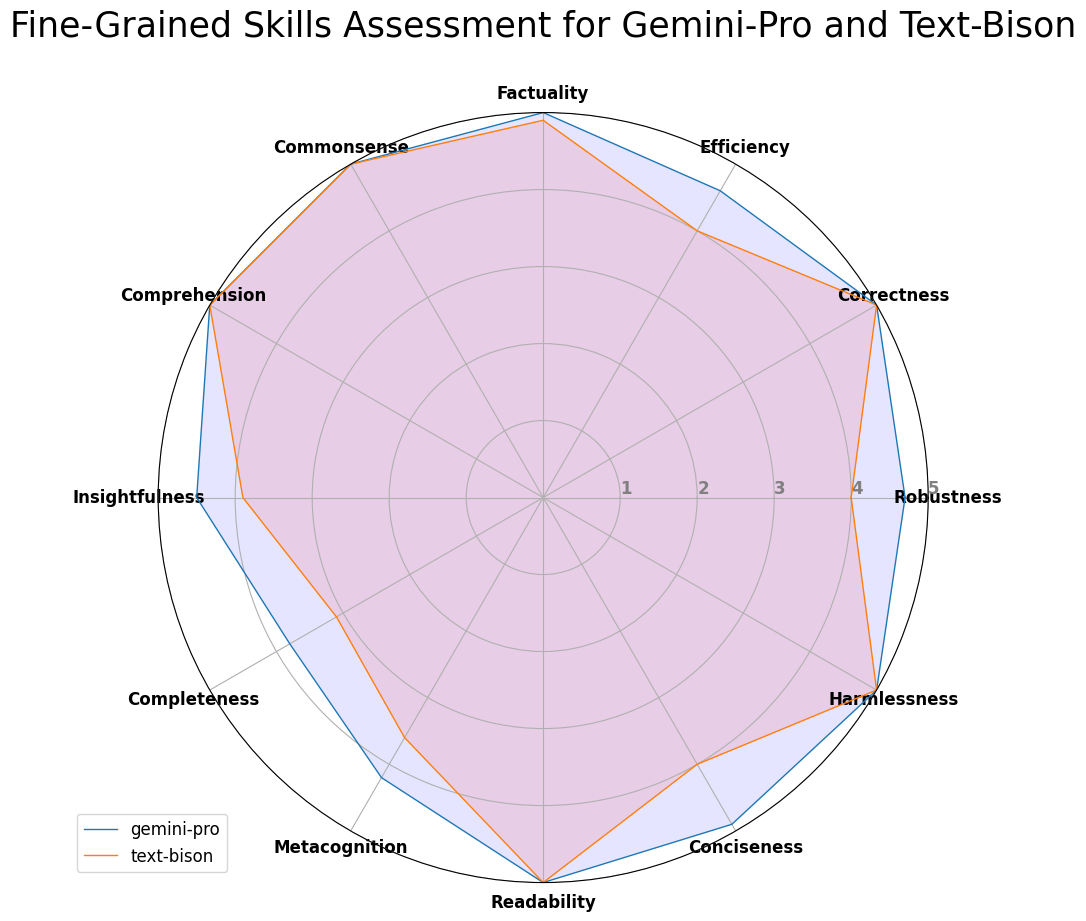

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from collections import defaultdict

# Data
avg_data = [literal_eval(score) for score in scores]
average_data = defaultdict(lambda: defaultdict(list))

# Accumulate the values for each model and attribute
for entry in avg_data:
    for model, attributes in entry.items():
        if isinstance(attributes, dict):
            for attribute, value in attributes.items():
                average_data[model][attribute].append(value)


# Calculate the averages
for model, attributes in average_data.items():
    for attribute, values in attributes.items():
        average_data[model][attribute] = sum(values) / len(values)

# Convert defaultdict to regular dict for display
average_data_dict = {model: dict(attributes) for model, attributes in average_data.items()}
average_data_dict = {key: average_data_dict[key] for key in ['Model A', 'Model B']}

# Convert to DataFrame
df = pd.DataFrame(average_data_dict)

# Number of variables
categories = list(df.index)
N = len(categories)

# What will be the angle of each axis in the plot?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, fontsize=12, fontweight='bold')

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=7, fontsize=12, fontweight='bold')
plt.ylim(0,5)

# Model A
values = list(df['Model A']) + list(df['Model A'])[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='gemini-pro')
ax.fill(angles, values, 'b', alpha=0.1)

# Model B
values = list(df['Model B']) + list(df['Model B'])[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='text-bison')
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)

plt.title('Fine-Grained Skills Assessment for Gemini-Pro and Text-Bison\n', fontsize=25)

# Show the plot
plt.show()